# Trajectrory Prediction using LSTM

## Author: Deeksha, Divya, Isha

In this notebook we are trying to predict the next location of a user using the LSTM model.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
df = pd.read_csv("levelB1_trajectory.csv",header=0)

In [2]:
df.head()

,ClientMacAddr,just_date,len_,loc_info
0,36,2018-04-17,74,"[('LB1', 1.2902421999999998, 103.851585, '09:1..."
1,36,2018-04-18,450,"[('LB1', 1.2908487, 103.85196, '09:32:56'), ('..."
2,36,2018-05-30,285,"[('LB1', 1.2908455, 103.852005, '16:05:20'), (..."
3,36,2018-06-15,323,"[('LB1', 1.2901448999999998, 103.85152, '14:42..."
4,36,2018-06-23,8,"[('LB1', 1.2903761, 103.851555, '10:24:50'), (..."


In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
import numpy as np
import math
import ast
import keras
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
def predict_next_location_ext_user(mac_id,level):
    if level=='B1':
        df = pd.read_csv("levelB1_trajectory.csv",header=0)
        
    data_mac_id = df[df['ClientMacAddr']==mac_id]
    trajectory = []
    for index, row in data_mac_id.iterrows():
        locInfo = ast.literal_eval(row['loc_info'])
        sequenceModelLat = []
        sequenceModelLong = []
        for i in range(len(locInfo)):
            #time = locInfo[i][3]
            lat = locInfo[i][1]
            long = locInfo[i][2]
            sequenceModelLat.append(lat)
            sequenceModelLong.append(long)
        #scale the values
        x_lat = pd.DataFrame(sequenceModelLat)
        x_long = pd.DataFrame(sequenceModelLong)
        valuesLat = x_lat.values 
        valuesLong = x_long.values
        #print("Hello lat and long")
        #print(valuesLat)
        #print(valuesLat)
        x_lat_scaled = scaleX(valuesLat)
        x_long_scaled = scaleX(valuesLong)
        #print("Hello scaled lat and long")
        #print(x_lat_scaled)
        #print(x_lat_scaled)
        reframed_lat = series_to_supervised(x_lat_scaled, 1, 1)
        reframed_long = series_to_supervised(x_long_scaled, 1, 1)
        pred_lat = train_model(reframed_lat) 
        pred_long = train_model(reframed_long)
        pred_point = (pred_lat[0],pred_long[0])
        rmse = (pred_lat[1],pred_long[1])
        trajectory.append((pred_point,rmse))
    return trajectory

Using TensorFlow backend.


In [5]:
def predict_next_location_ext_user1(mac_id,traj,level):
    if level=='B1':
        df = pd.read_csv("levelB1_trajectory.csv",header=0)
        
    data_mac_id = df[df['ClientMacAddr']==mac_id]
    minDistance = 9999999999999999999
    keyIndex = 0
    keyRow = 0
    for index, row in data_mac_id.iterrows():
        locInfo = ast.literal_eval(row['loc_info'])
        sumDist = 0
        sequenceModelLat_test = []
        sequenceModelLong_test = []
        for x in range(min(len(traj),3)):
            lat = locInfo[x][1]
            longg = locInfo[x][2]
            plat = traj[x][0]
            plong = traj[x][1]
            sequenceModelLat_test.append(plat)
            sequenceModelLong_test.append(plong)            
            dist = math.hypot(plat - lat, plong - longg)
            sumDist += dist
        if sumDist < minDistance:
            minDistance = min(minDistance, dist)
            keyIndex = index
            keyRow = row
    for row in keyRow:
        locInfo = ast.literal_eval(row)    
        sequenceModelLat = []
        sequenceModelLong = []
        for i in range(len(locInfo)):
            #time = locInfo[i][3]
            lat = locInfo[i][1]
            longg = locInfo[i][2]
            sequenceModelLat.append(lat)
            sequenceModelLong.append(long)
        #scale the train values
        x_lat = pd.DataFrame(sequenceModelLat)
        x_long = pd.DataFrame(sequenceModelLong)
        valuesLat = x_lat.values 
        valuesLong = x_long.values
        x_lat_scaled = scaleX(valuesLat)
        x_long_scaled = scaleX(valuesLong)
        reframed_lat = series_to_supervised(x_lat_scaled, 1, 1)
        reframed_long = series_to_supervised(x_long_scaled, 1, 1)
        #scaled the test values
        xtest_lat = pd.DataFrame(sequenceModelLat_test)
        xtest_long = pd.DataFrame(sequenceModelLong_test)
        valuesLat_test = xtest_lat.values 
        valuesLong_test = xtest_long.values
        x_lat_scaled_test = scaleX(valuesLat_test)
        x_long_scaled_test = scaleX(valuesLong_test)
        reframed_lat_test = series_to_supervised(x_lat_scaled_test, 1, 1)
        reframed_long_test = series_to_supervised(x_long_scaled_test, 1, 1)
        #train the model 
        pred_lat = train_model1(reframed_lat,reframed_lat_test) 
        pred_long = train_model1(reframed_long,reframed_long_test)
        pred_point = (pred_lat[0],pred_long[0])
        trajectory.append(pred_point)

In [6]:
def train_model1(reframed,test_ref):
    values = reframed.values
    values_test = test_ref.values
    #n_train_time = 0.7 * len(values)
    train = values
    test = values_test
    train_X, train_y = train[:, :1], train[:, 1:]
    test_X= test[:, :]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #train the model
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    #    model.add(LSTM(70))
    #    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    # make a prediction
    yhat = model.predict(test_X)
    pred_y = yhat[len(yhat)-1]
    return (pred_y,rmse)

In [7]:
def scaleX(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaled

In [8]:
def train_model(reframed):
    values = reframed.values
    #print(values)
    n_train_time = int(0.7 * len(values))
    print(n_train_time)
    train = values[:n_train_time, :]
    test = values[n_train_time:, :]
    train_X, train_y = train[:, :1], train[:, 1:]
    test_X, test_y = test[:, :1], test[:,1:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #train the model
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    #    model.add(LSTM(70))
    #    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    # make a prediction
    yhat = model.predict(test_X)
    pred_y = yhat[len(yhat)-1]
    rmse = math.sqrt(mean_squared_error(yhat, test_y))   
    return (pred_y,rmse)




### LSTM and Loss Functions on Level B1 dataset

132
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 132 samples, validate on 57 samples
Epoch 1/20
 - 2s - loss: 0.4120 - val_loss: 0.2749
Epoch 2/20
 - 0s - loss: 0.3983 - val_loss: 0.2664
Epoch 3/20
 - 0s - loss: 0.3867 - val_loss: 0.2582
Epoch 4/20
 - 0s - loss: 0.3762 - val_loss: 0.2503
Epoch 5/20
 - 0s - loss: 0.3637 - val_loss: 0.2425
Epoch 6/20
 - 0s - loss: 0.3543 - val_loss: 0.2349
Epoch 7/20
 - 0s - loss: 0.3415 - val_loss: 0.2275
Epoch 8/20
 - 0s - loss: 0.3324 - val_loss: 0.2203
Epoch 9/20
 - 0s - loss: 0.3191 - val_loss: 0.2132
Epoch 10/20
 - 0s - loss: 0.3111 - val_loss: 0.2062
Epoch 11/20
 - 0s - loss: 0.3030 - val_loss: 0.1994
Epoch 12/20
 - 0s - loss: 0.2917 - val_loss: 0.1927
Epoch 13/20
 - 0s - loss: 0.2797 - val_loss: 0.1862
Epoch 14/20
 - 0s - loss: 0.2700 - val_loss: 0.17

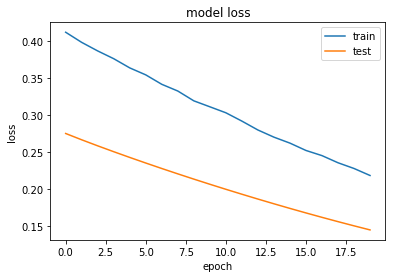

132
Train on 132 samples, validate on 57 samples
Epoch 1/20
 - 1s - loss: 0.4516 - val_loss: 0.3055
Epoch 2/20
 - 0s - loss: 0.4387 - val_loss: 0.2950
Epoch 3/20
 - 0s - loss: 0.4216 - val_loss: 0.2850
Epoch 4/20
 - 0s - loss: 0.4096 - val_loss: 0.2753
Epoch 5/20
 - 0s - loss: 0.3970 - val_loss: 0.2659
Epoch 6/20
 - 0s - loss: 0.3819 - val_loss: 0.2567
Epoch 7/20
 - 0s - loss: 0.3702 - val_loss: 0.2477
Epoch 8/20
 - 0s - loss: 0.3602 - val_loss: 0.2390
Epoch 9/20
 - 0s - loss: 0.3448 - val_loss: 0.2304
Epoch 10/20
 - 0s - loss: 0.3341 - val_loss: 0.2220
Epoch 11/20
 - 0s - loss: 0.3218 - val_loss: 0.2139
Epoch 12/20
 - 0s - loss: 0.3093 - val_loss: 0.2059
Epoch 13/20
 - 0s - loss: 0.2994 - val_loss: 0.1981
Epoch 14/20
 - 0s - loss: 0.2897 - val_loss: 0.1905
Epoch 15/20
 - 0s - loss: 0.2778 - val_loss: 0.1830
Epoch 16/20
 - 0s - loss: 0.2630 - val_loss: 0.1758
Epoch 17/20
 - 0s - loss: 0.2556 - val_loss: 0.1687
Epoch 18/20
 - 0s - loss: 0.2446 - val_loss: 0.1618
Epoch 19/20
 - 0s - loss

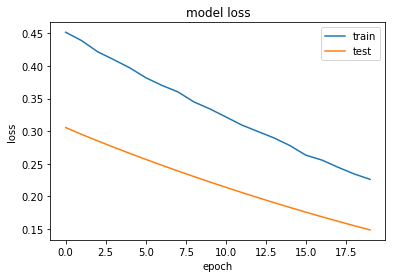

826
Train on 826 samples, validate on 354 samples
Epoch 1/20
 - 1s - loss: 0.2661 - val_loss: 0.0968
Epoch 2/20
 - 0s - loss: 0.2101 - val_loss: 0.0674
Epoch 3/20
 - 0s - loss: 0.1613 - val_loss: 0.0436
Epoch 4/20
 - 0s - loss: 0.1199 - val_loss: 0.0263
Epoch 5/20
 - 0s - loss: 0.0853 - val_loss: 0.0161
Epoch 6/20
 - 0s - loss: 0.0613 - val_loss: 0.0124
Epoch 7/20
 - 0s - loss: 0.0451 - val_loss: 0.0133
Epoch 8/20
 - 0s - loss: 0.0360 - val_loss: 0.0160
Epoch 9/20
 - 0s - loss: 0.0314 - val_loss: 0.0184
Epoch 10/20
 - 0s - loss: 0.0289 - val_loss: 0.0196
Epoch 11/20
 - 0s - loss: 0.0267 - val_loss: 0.0197
Epoch 12/20
 - 0s - loss: 0.0263 - val_loss: 0.0192
Epoch 13/20
 - 0s - loss: 0.0253 - val_loss: 0.0184
Epoch 14/20
 - 0s - loss: 0.0233 - val_loss: 0.0174
Epoch 15/20
 - 0s - loss: 0.0223 - val_loss: 0.0165
Epoch 16/20
 - 0s - loss: 0.0213 - val_loss: 0.0157
Epoch 17/20
 - 0s - loss: 0.0209 - val_loss: 0.0151
Epoch 18/20
 - 0s - loss: 0.0194 - val_loss: 0.0144
Epoch 19/20
 - 0s - los

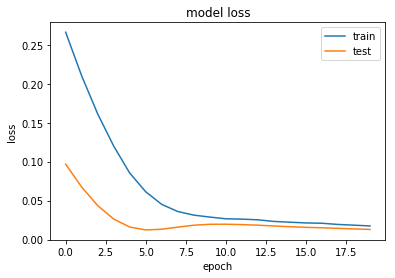

826
Train on 826 samples, validate on 354 samples
Epoch 1/20
 - 1s - loss: 0.2304 - val_loss: 0.0551
Epoch 2/20
 - 0s - loss: 0.1795 - val_loss: 0.0349
Epoch 3/20
 - 0s - loss: 0.1387 - val_loss: 0.0204
Epoch 4/20
 - 0s - loss: 0.1044 - val_loss: 0.0116
Epoch 5/20
 - 0s - loss: 0.0796 - val_loss: 0.0083
Epoch 6/20
 - 0s - loss: 0.0601 - val_loss: 0.0091
Epoch 7/20
 - 0s - loss: 0.0485 - val_loss: 0.0122
Epoch 8/20
 - 0s - loss: 0.0405 - val_loss: 0.0156
Epoch 9/20
 - 0s - loss: 0.0365 - val_loss: 0.0183
Epoch 10/20
 - 0s - loss: 0.0339 - val_loss: 0.0197
Epoch 11/20
 - 0s - loss: 0.0320 - val_loss: 0.0200
Epoch 12/20
 - 0s - loss: 0.0306 - val_loss: 0.0197
Epoch 13/20
 - 0s - loss: 0.0292 - val_loss: 0.0190
Epoch 14/20
 - 0s - loss: 0.0270 - val_loss: 0.0182
Epoch 15/20
 - 0s - loss: 0.0260 - val_loss: 0.0173
Epoch 16/20
 - 0s - loss: 0.0249 - val_loss: 0.0165
Epoch 17/20
 - 0s - loss: 0.0238 - val_loss: 0.0157
Epoch 18/20
 - 0s - loss: 0.0230 - val_loss: 0.0150
Epoch 19/20
 - 0s - los

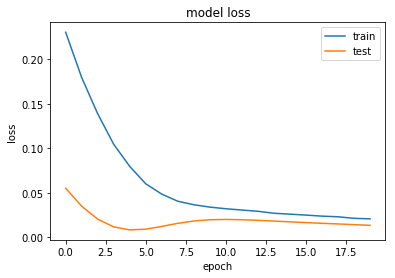

644
Train on 644 samples, validate on 277 samples
Epoch 1/20
 - 1s - loss: 0.4078 - val_loss: 0.0692
Epoch 2/20
 - 0s - loss: 0.3432 - val_loss: 0.0490
Epoch 3/20
 - 0s - loss: 0.2843 - val_loss: 0.0324
Epoch 4/20
 - 0s - loss: 0.2315 - val_loss: 0.0196
Epoch 5/20
 - 0s - loss: 0.1827 - val_loss: 0.0112
Epoch 6/20
 - 0s - loss: 0.1406 - val_loss: 0.0074
Epoch 7/20
 - 0s - loss: 0.1075 - val_loss: 0.0082
Epoch 8/20
 - 0s - loss: 0.0821 - val_loss: 0.0126
Epoch 9/20
 - 0s - loss: 0.0631 - val_loss: 0.0191
Epoch 10/20
 - 0s - loss: 0.0517 - val_loss: 0.0258
Epoch 11/20
 - 0s - loss: 0.0444 - val_loss: 0.0312
Epoch 12/20
 - 0s - loss: 0.0400 - val_loss: 0.0345
Epoch 13/20
 - 0s - loss: 0.0374 - val_loss: 0.0358
Epoch 14/20
 - 0s - loss: 0.0353 - val_loss: 0.0355
Epoch 15/20
 - 0s - loss: 0.0337 - val_loss: 0.0343
Epoch 16/20
 - 0s - loss: 0.0320 - val_loss: 0.0329
Epoch 17/20
 - 0s - loss: 0.0315 - val_loss: 0.0314
Epoch 18/20
 - 0s - loss: 0.0297 - val_loss: 0.0299
Epoch 19/20
 - 0s - los

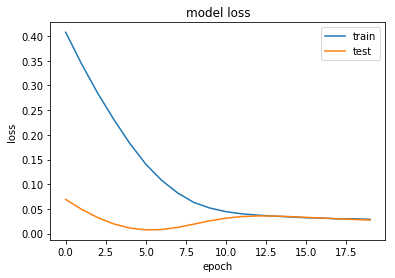

644
Train on 644 samples, validate on 277 samples
Epoch 1/20
 - 1s - loss: 0.4516 - val_loss: 0.0231
Epoch 2/20
 - 0s - loss: 0.3850 - val_loss: 0.0147
Epoch 3/20
 - 0s - loss: 0.3261 - val_loss: 0.0090
Epoch 4/20
 - 0s - loss: 0.2713 - val_loss: 0.0061
Epoch 5/20
 - 0s - loss: 0.2203 - val_loss: 0.0063
Epoch 6/20
 - 0s - loss: 0.1763 - val_loss: 0.0100
Epoch 7/20
 - 0s - loss: 0.1363 - val_loss: 0.0170
Epoch 8/20
 - 0s - loss: 0.1040 - val_loss: 0.0264
Epoch 9/20
 - 0s - loss: 0.0799 - val_loss: 0.0371
Epoch 10/20
 - 0s - loss: 0.0636 - val_loss: 0.0473
Epoch 11/20
 - 0s - loss: 0.0526 - val_loss: 0.0557
Epoch 12/20
 - 0s - loss: 0.0455 - val_loss: 0.0612
Epoch 13/20
 - 0s - loss: 0.0404 - val_loss: 0.0636
Epoch 14/20
 - 0s - loss: 0.0376 - val_loss: 0.0636
Epoch 15/20
 - 0s - loss: 0.0357 - val_loss: 0.0622
Epoch 16/20
 - 0s - loss: 0.0332 - val_loss: 0.0597
Epoch 17/20
 - 0s - loss: 0.0318 - val_loss: 0.0568
Epoch 18/20
 - 0s - loss: 0.0312 - val_loss: 0.0542
Epoch 19/20
 - 0s - los

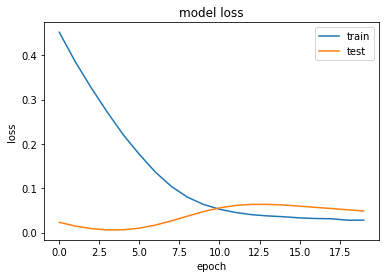

503
Train on 503 samples, validate on 216 samples
Epoch 1/20
 - 2s - loss: 0.4396 - val_loss: 0.0820
Epoch 2/20
 - 0s - loss: 0.3842 - val_loss: 0.0645
Epoch 3/20
 - 0s - loss: 0.3375 - val_loss: 0.0496
Epoch 4/20
 - 0s - loss: 0.2948 - val_loss: 0.0371
Epoch 5/20
 - 0s - loss: 0.2556 - val_loss: 0.0269
Epoch 6/20
 - 0s - loss: 0.2194 - val_loss: 0.0190
Epoch 7/20
 - 0s - loss: 0.1856 - val_loss: 0.0136
Epoch 8/20
 - 0s - loss: 0.1555 - val_loss: 0.0104
Epoch 9/20
 - 0s - loss: 0.1329 - val_loss: 0.0095
Epoch 10/20
 - 0s - loss: 0.1104 - val_loss: 0.0105
Epoch 11/20
 - 0s - loss: 0.0934 - val_loss: 0.0129
Epoch 12/20
 - 0s - loss: 0.0783 - val_loss: 0.0161
Epoch 13/20
 - 0s - loss: 0.0700 - val_loss: 0.0196
Epoch 14/20
 - 0s - loss: 0.0622 - val_loss: 0.0229
Epoch 15/20
 - 0s - loss: 0.0551 - val_loss: 0.0257
Epoch 16/20
 - 0s - loss: 0.0522 - val_loss: 0.0275
Epoch 17/20
 - 0s - loss: 0.0508 - val_loss: 0.0287
Epoch 18/20
 - 0s - loss: 0.0470 - val_loss: 0.0292
Epoch 19/20
 - 0s - los

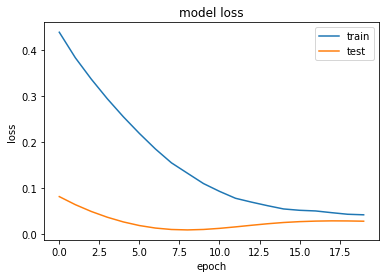

503
Train on 503 samples, validate on 216 samples
Epoch 1/20
 - 2s - loss: 0.4035 - val_loss: 0.0508
Epoch 2/20
 - 0s - loss: 0.3619 - val_loss: 0.0393
Epoch 3/20
 - 0s - loss: 0.3240 - val_loss: 0.0296
Epoch 4/20
 - 0s - loss: 0.2880 - val_loss: 0.0216
Epoch 5/20
 - 0s - loss: 0.2554 - val_loss: 0.0153
Epoch 6/20
 - 0s - loss: 0.2264 - val_loss: 0.0107
Epoch 7/20
 - 0s - loss: 0.1999 - val_loss: 0.0078
Epoch 8/20
 - 0s - loss: 0.1742 - val_loss: 0.0065
Epoch 9/20
 - 0s - loss: 0.1530 - val_loss: 0.0068
Epoch 10/20
 - 0s - loss: 0.1342 - val_loss: 0.0084
Epoch 11/20
 - 0s - loss: 0.1154 - val_loss: 0.0111
Epoch 12/20
 - 0s - loss: 0.1045 - val_loss: 0.0145
Epoch 13/20
 - 0s - loss: 0.0904 - val_loss: 0.0182
Epoch 14/20
 - 0s - loss: 0.0841 - val_loss: 0.0219
Epoch 15/20
 - 0s - loss: 0.0761 - val_loss: 0.0251
Epoch 16/20
 - 0s - loss: 0.0707 - val_loss: 0.0277
Epoch 17/20
 - 0s - loss: 0.0658 - val_loss: 0.0296
Epoch 18/20
 - 0s - loss: 0.0630 - val_loss: 0.0308
Epoch 19/20
 - 0s - los

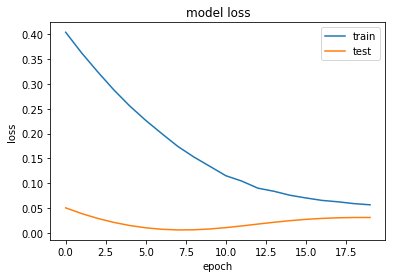

8
Train on 8 samples, validate on 4 samples
Epoch 1/20
 - 2s - loss: 0.0476 - val_loss: 0.6009
Epoch 2/20
 - 0s - loss: 0.0486 - val_loss: 0.5901
Epoch 3/20
 - 0s - loss: 0.0469 - val_loss: 0.5794
Epoch 4/20
 - 0s - loss: 0.0434 - val_loss: 0.5691
Epoch 5/20
 - 0s - loss: 0.0435 - val_loss: 0.5588
Epoch 6/20
 - 0s - loss: 0.0393 - val_loss: 0.5487
Epoch 7/20
 - 0s - loss: 0.0393 - val_loss: 0.5387
Epoch 8/20
 - 0s - loss: 0.0383 - val_loss: 0.5289
Epoch 9/20
 - 0s - loss: 0.0361 - val_loss: 0.5193
Epoch 10/20
 - 0s - loss: 0.0359 - val_loss: 0.5099
Epoch 11/20
 - 0s - loss: 0.0334 - val_loss: 0.5006
Epoch 12/20
 - 0s - loss: 0.0350 - val_loss: 0.4914
Epoch 13/20
 - 0s - loss: 0.0303 - val_loss: 0.4824
Epoch 14/20
 - 0s - loss: 0.0315 - val_loss: 0.4736
Epoch 15/20
 - 0s - loss: 0.0298 - val_loss: 0.4650
Epoch 16/20
 - 0s - loss: 0.0284 - val_loss: 0.4565
Epoch 17/20
 - 0s - loss: 0.0300 - val_loss: 0.4482
Epoch 18/20
 - 0s - loss: 0.0279 - val_loss: 0.4401
Epoch 19/20
 - 0s - loss: 0.0

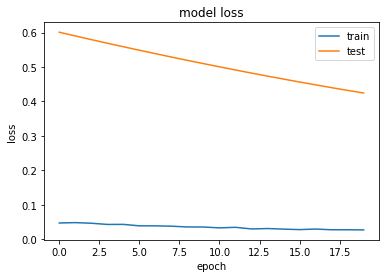

8
Train on 8 samples, validate on 4 samples
Epoch 1/20
 - 2s - loss: 0.0672 - val_loss: 0.5497
Epoch 2/20
 - 0s - loss: 0.0649 - val_loss: 0.5402
Epoch 3/20
 - 0s - loss: 0.0619 - val_loss: 0.5308
Epoch 4/20
 - 0s - loss: 0.0589 - val_loss: 0.5215
Epoch 5/20
 - 0s - loss: 0.0587 - val_loss: 0.5124
Epoch 6/20
 - 0s - loss: 0.0557 - val_loss: 0.5034
Epoch 7/20
 - 0s - loss: 0.0527 - val_loss: 0.4945
Epoch 8/20
 - 0s - loss: 0.0513 - val_loss: 0.4857
Epoch 9/20
 - 0s - loss: 0.0509 - val_loss: 0.4770
Epoch 10/20
 - 0s - loss: 0.0477 - val_loss: 0.4684
Epoch 11/20
 - 0s - loss: 0.0470 - val_loss: 0.4600
Epoch 12/20
 - 0s - loss: 0.0430 - val_loss: 0.4516
Epoch 13/20
 - 0s - loss: 0.0431 - val_loss: 0.4434
Epoch 14/20
 - 0s - loss: 0.0417 - val_loss: 0.4352
Epoch 15/20
 - 0s - loss: 0.0401 - val_loss: 0.4272
Epoch 16/20
 - 0s - loss: 0.0389 - val_loss: 0.4193
Epoch 17/20
 - 0s - loss: 0.0369 - val_loss: 0.4115
Epoch 18/20
 - 0s - loss: 0.0357 - val_loss: 0.4038
Epoch 19/20
 - 0s - loss: 0.0

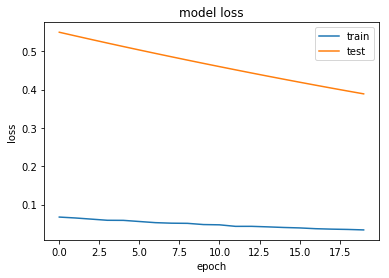

4
Train on 4 samples, validate on 3 samples
Epoch 1/20
 - 2s - loss: 0.4114 - val_loss: 0.0098
Epoch 2/20
 - 0s - loss: 0.4062 - val_loss: 0.0095
Epoch 3/20
 - 0s - loss: 0.4023 - val_loss: 0.0094
Epoch 4/20
 - 0s - loss: 0.3928 - val_loss: 0.0093
Epoch 5/20
 - 0s - loss: 0.3941 - val_loss: 0.0092
Epoch 6/20
 - 0s - loss: 0.3869 - val_loss: 0.0093
Epoch 7/20
 - 0s - loss: 0.3694 - val_loss: 0.0094
Epoch 8/20
 - 0s - loss: 0.3657 - val_loss: 0.0096
Epoch 9/20
 - 0s - loss: 0.3686 - val_loss: 0.0098
Epoch 10/20
 - 0s - loss: 0.3510 - val_loss: 0.0102
Epoch 11/20
 - 0s - loss: 0.3478 - val_loss: 0.0105
Epoch 12/20
 - 0s - loss: 0.3440 - val_loss: 0.0110
Epoch 13/20
 - 0s - loss: 0.3414 - val_loss: 0.0115
Epoch 14/20
 - 0s - loss: 0.3270 - val_loss: 0.0122
Epoch 15/20
 - 0s - loss: 0.3281 - val_loss: 0.0128
Epoch 16/20
 - 0s - loss: 0.3174 - val_loss: 0.0136
Epoch 17/20
 - 0s - loss: 0.3151 - val_loss: 0.0144
Epoch 18/20
 - 0s - loss: 0.3090 - val_loss: 0.0153
Epoch 19/20
 - 0s - loss: 0.2

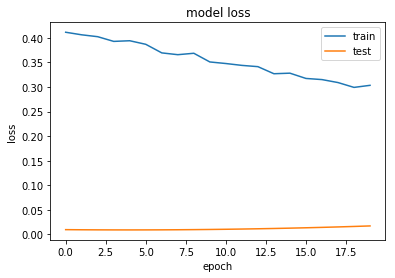

4
Train on 4 samples, validate on 3 samples
Epoch 1/20
 - 2s - loss: 0.3083 - val_loss: 0.0160
Epoch 2/20
 - 0s - loss: 0.3048 - val_loss: 0.0156
Epoch 3/20
 - 0s - loss: 0.2986 - val_loss: 0.0152
Epoch 4/20
 - 0s - loss: 0.2925 - val_loss: 0.0149
Epoch 5/20
 - 0s - loss: 0.2904 - val_loss: 0.0147
Epoch 6/20
 - 0s - loss: 0.2896 - val_loss: 0.0145
Epoch 7/20
 - 0s - loss: 0.2805 - val_loss: 0.0144
Epoch 8/20
 - 0s - loss: 0.2758 - val_loss: 0.0144
Epoch 9/20
 - 0s - loss: 0.2754 - val_loss: 0.0144
Epoch 10/20
 - 0s - loss: 0.2710 - val_loss: 0.0145
Epoch 11/20
 - 0s - loss: 0.2686 - val_loss: 0.0146
Epoch 12/20
 - 0s - loss: 0.2658 - val_loss: 0.0148
Epoch 13/20
 - 0s - loss: 0.2580 - val_loss: 0.0151
Epoch 14/20
 - 0s - loss: 0.2584 - val_loss: 0.0154
Epoch 15/20
 - 0s - loss: 0.2527 - val_loss: 0.0158
Epoch 16/20
 - 0s - loss: 0.2525 - val_loss: 0.0163
Epoch 17/20
 - 0s - loss: 0.2475 - val_loss: 0.0169
Epoch 18/20
 - 0s - loss: 0.2398 - val_loss: 0.0175
Epoch 19/20
 - 0s - loss: 0.2

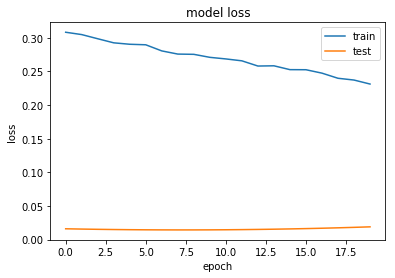

182
Train on 182 samples, validate on 78 samples
Epoch 1/20
 - 2s - loss: 0.4163 - val_loss: 0.3009
Epoch 2/20
 - 0s - loss: 0.3914 - val_loss: 0.2820
Epoch 3/20
 - 0s - loss: 0.3684 - val_loss: 0.2639
Epoch 4/20
 - 0s - loss: 0.3461 - val_loss: 0.2466
Epoch 5/20
 - 0s - loss: 0.3244 - val_loss: 0.2300
Epoch 6/20
 - 0s - loss: 0.3037 - val_loss: 0.2141
Epoch 7/20
 - 0s - loss: 0.2843 - val_loss: 0.1988
Epoch 8/20
 - 0s - loss: 0.2646 - val_loss: 0.1841
Epoch 9/20
 - 0s - loss: 0.2456 - val_loss: 0.1700
Epoch 10/20
 - 0s - loss: 0.2290 - val_loss: 0.1564
Epoch 11/20
 - 0s - loss: 0.2102 - val_loss: 0.1435
Epoch 12/20
 - 0s - loss: 0.1942 - val_loss: 0.1312
Epoch 13/20
 - 0s - loss: 0.1772 - val_loss: 0.1196
Epoch 14/20
 - 0s - loss: 0.1626 - val_loss: 0.1087
Epoch 15/20
 - 0s - loss: 0.1502 - val_loss: 0.0985
Epoch 16/20
 - 0s - loss: 0.1345 - val_loss: 0.0892
Epoch 17/20
 - 0s - loss: 0.1237 - val_loss: 0.0808
Epoch 18/20
 - 0s - loss: 0.1108 - val_loss: 0.0733
Epoch 19/20
 - 0s - loss

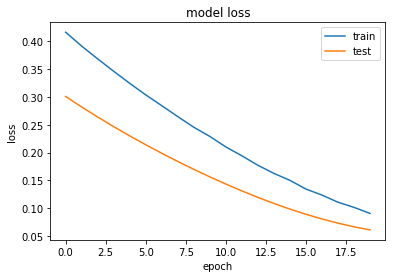

182
Train on 182 samples, validate on 78 samples
Epoch 1/20
 - 3s - loss: 0.3883 - val_loss: 0.2915
Epoch 2/20
 - 0s - loss: 0.3649 - val_loss: 0.2719
Epoch 3/20
 - 0s - loss: 0.3416 - val_loss: 0.2529
Epoch 4/20
 - 0s - loss: 0.3195 - val_loss: 0.2345
Epoch 5/20
 - 0s - loss: 0.2986 - val_loss: 0.2168
Epoch 6/20
 - 0s - loss: 0.2776 - val_loss: 0.1996
Epoch 7/20
 - 0s - loss: 0.2578 - val_loss: 0.1830
Epoch 8/20
 - 0s - loss: 0.2377 - val_loss: 0.1670
Epoch 9/20
 - 0s - loss: 0.2187 - val_loss: 0.1516
Epoch 10/20
 - 0s - loss: 0.2002 - val_loss: 0.1369
Epoch 11/20
 - 0s - loss: 0.1847 - val_loss: 0.1228
Epoch 12/20
 - 0s - loss: 0.1676 - val_loss: 0.1096
Epoch 13/20
 - 0s - loss: 0.1499 - val_loss: 0.0972
Epoch 14/20
 - 0s - loss: 0.1352 - val_loss: 0.0857
Epoch 15/20
 - 0s - loss: 0.1222 - val_loss: 0.0751
Epoch 16/20
 - 0s - loss: 0.1086 - val_loss: 0.0655
Epoch 17/20
 - 0s - loss: 0.0960 - val_loss: 0.0570
Epoch 18/20
 - 0s - loss: 0.0869 - val_loss: 0.0496
Epoch 19/20
 - 0s - loss

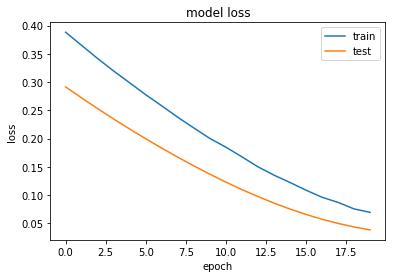

5
Train on 5 samples, validate on 3 samples
Epoch 1/20
 - 3s - loss: 0.5695 - val_loss: 0.6616
Epoch 2/20
 - 0s - loss: 0.5817 - val_loss: 0.6566
Epoch 3/20
 - 0s - loss: 0.5691 - val_loss: 0.6518
Epoch 4/20
 - 0s - loss: 0.5718 - val_loss: 0.6469
Epoch 5/20
 - 0s - loss: 0.5574 - val_loss: 0.6421
Epoch 6/20
 - 0s - loss: 0.5492 - val_loss: 0.6374
Epoch 7/20
 - 0s - loss: 0.5552 - val_loss: 0.6327
Epoch 8/20
 - 0s - loss: 0.5375 - val_loss: 0.6281
Epoch 9/20
 - 0s - loss: 0.5360 - val_loss: 0.6236
Epoch 10/20
 - 0s - loss: 0.5305 - val_loss: 0.6190
Epoch 11/20
 - 0s - loss: 0.5273 - val_loss: 0.6145
Epoch 12/20
 - 0s - loss: 0.5201 - val_loss: 0.6100
Epoch 13/20
 - 0s - loss: 0.5178 - val_loss: 0.6056
Epoch 14/20
 - 0s - loss: 0.5135 - val_loss: 0.6012
Epoch 15/20
 - 0s - loss: 0.5025 - val_loss: 0.5968
Epoch 16/20
 - 0s - loss: 0.5008 - val_loss: 0.5925
Epoch 17/20
 - 0s - loss: 0.4947 - val_loss: 0.5882
Epoch 18/20
 - 0s - loss: 0.4802 - val_loss: 0.5839
Epoch 19/20
 - 0s - loss: 0.4

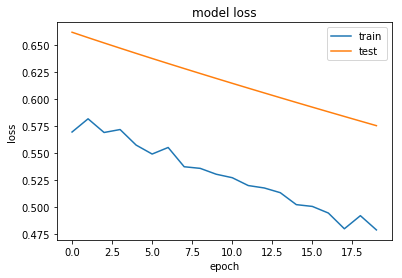

5
Train on 5 samples, validate on 3 samples
Epoch 1/20
 - 3s - loss: 0.5040 - val_loss: 0.6616
Epoch 2/20
 - 0s - loss: 0.5049 - val_loss: 0.6566
Epoch 3/20
 - 0s - loss: 0.4882 - val_loss: 0.6517
Epoch 4/20
 - 0s - loss: 0.4854 - val_loss: 0.6469
Epoch 5/20
 - 0s - loss: 0.4864 - val_loss: 0.6422
Epoch 6/20
 - 0s - loss: 0.4762 - val_loss: 0.6375
Epoch 7/20
 - 0s - loss: 0.4679 - val_loss: 0.6328
Epoch 8/20
 - 0s - loss: 0.4628 - val_loss: 0.6282
Epoch 9/20
 - 0s - loss: 0.4637 - val_loss: 0.6236
Epoch 10/20
 - 0s - loss: 0.4573 - val_loss: 0.6191
Epoch 11/20
 - 0s - loss: 0.4526 - val_loss: 0.6145
Epoch 12/20
 - 0s - loss: 0.4541 - val_loss: 0.6101
Epoch 13/20
 - 0s - loss: 0.4475 - val_loss: 0.6056
Epoch 14/20
 - 0s - loss: 0.4430 - val_loss: 0.6012
Epoch 15/20
 - 0s - loss: 0.4371 - val_loss: 0.5968
Epoch 16/20
 - 0s - loss: 0.4307 - val_loss: 0.5924
Epoch 17/20
 - 0s - loss: 0.4240 - val_loss: 0.5881
Epoch 18/20
 - 0s - loss: 0.4218 - val_loss: 0.5837
Epoch 19/20
 - 0s - loss: 0.4

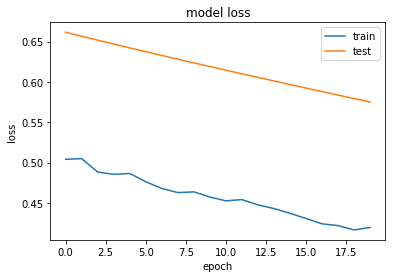

314
Train on 314 samples, validate on 135 samples
Epoch 1/20
 - 3s - loss: 0.1758 - val_loss: 0.4484
Epoch 2/20
 - 0s - loss: 0.1618 - val_loss: 0.4197
Epoch 3/20
 - 0s - loss: 0.1505 - val_loss: 0.3917
Epoch 4/20
 - 0s - loss: 0.1389 - val_loss: 0.3646
Epoch 5/20
 - 0s - loss: 0.1284 - val_loss: 0.3387
Epoch 6/20
 - 0s - loss: 0.1171 - val_loss: 0.3138
Epoch 7/20
 - 0s - loss: 0.1089 - val_loss: 0.2900
Epoch 8/20
 - 0s - loss: 0.1000 - val_loss: 0.2674
Epoch 9/20
 - 0s - loss: 0.0924 - val_loss: 0.2459
Epoch 10/20
 - 0s - loss: 0.0853 - val_loss: 0.2257
Epoch 11/20
 - 0s - loss: 0.0777 - val_loss: 0.2068
Epoch 12/20
 - 0s - loss: 0.0735 - val_loss: 0.1891
Epoch 13/20
 - 0s - loss: 0.0691 - val_loss: 0.1729
Epoch 14/20
 - 0s - loss: 0.0638 - val_loss: 0.1579
Epoch 15/20
 - 0s - loss: 0.0606 - val_loss: 0.1442
Epoch 16/20
 - 0s - loss: 0.0577 - val_loss: 0.1319
Epoch 17/20
 - 0s - loss: 0.0547 - val_loss: 0.1209
Epoch 18/20
 - 0s - loss: 0.0530 - val_loss: 0.1110
Epoch 19/20
 - 0s - los

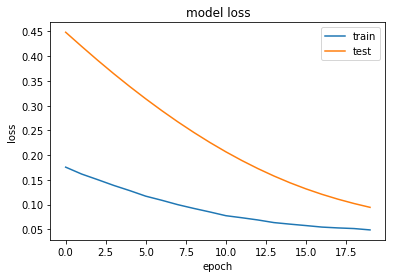

314
Train on 314 samples, validate on 135 samples
Epoch 1/20
 - 3s - loss: 0.1702 - val_loss: 0.3973
Epoch 2/20
 - 0s - loss: 0.1595 - val_loss: 0.3729
Epoch 3/20
 - 0s - loss: 0.1488 - val_loss: 0.3491
Epoch 4/20
 - 0s - loss: 0.1391 - val_loss: 0.3263
Epoch 5/20
 - 0s - loss: 0.1320 - val_loss: 0.3047
Epoch 6/20
 - 0s - loss: 0.1228 - val_loss: 0.2843
Epoch 7/20
 - 0s - loss: 0.1148 - val_loss: 0.2650
Epoch 8/20
 - 0s - loss: 0.1080 - val_loss: 0.2468
Epoch 9/20
 - 0s - loss: 0.1014 - val_loss: 0.2296
Epoch 10/20
 - 0s - loss: 0.0957 - val_loss: 0.2135
Epoch 11/20
 - 0s - loss: 0.0908 - val_loss: 0.1983
Epoch 12/20
 - 0s - loss: 0.0859 - val_loss: 0.1841
Epoch 13/20
 - 0s - loss: 0.0815 - val_loss: 0.1709
Epoch 14/20
 - 0s - loss: 0.0779 - val_loss: 0.1586
Epoch 15/20
 - 0s - loss: 0.0745 - val_loss: 0.1472
Epoch 16/20
 - 0s - loss: 0.0703 - val_loss: 0.1366
Epoch 17/20
 - 0s - loss: 0.0678 - val_loss: 0.1269
Epoch 18/20
 - 0s - loss: 0.0658 - val_loss: 0.1180
Epoch 19/20
 - 0s - los

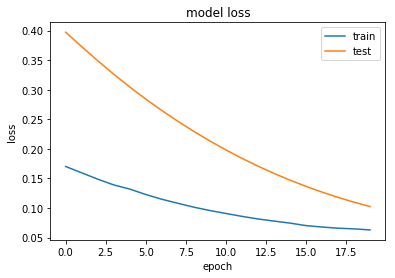

278
Train on 278 samples, validate on 120 samples
Epoch 1/20
 - 3s - loss: 0.1585 - val_loss: 0.5779
Epoch 2/20
 - 0s - loss: 0.1431 - val_loss: 0.5364
Epoch 3/20
 - 0s - loss: 0.1273 - val_loss: 0.4969
Epoch 4/20
 - 0s - loss: 0.1136 - val_loss: 0.4590
Epoch 5/20
 - 0s - loss: 0.1009 - val_loss: 0.4226
Epoch 6/20
 - 0s - loss: 0.0886 - val_loss: 0.3875
Epoch 7/20
 - 0s - loss: 0.0771 - val_loss: 0.3539
Epoch 8/20
 - 0s - loss: 0.0664 - val_loss: 0.3215
Epoch 9/20
 - 0s - loss: 0.0568 - val_loss: 0.2907
Epoch 10/20
 - 0s - loss: 0.0473 - val_loss: 0.2614
Epoch 11/20
 - 0s - loss: 0.0400 - val_loss: 0.2339
Epoch 12/20
 - 0s - loss: 0.0340 - val_loss: 0.2085
Epoch 13/20
 - 0s - loss: 0.0285 - val_loss: 0.1853
Epoch 14/20
 - 0s - loss: 0.0240 - val_loss: 0.1647
Epoch 15/20
 - 0s - loss: 0.0212 - val_loss: 0.1466
Epoch 16/20
 - 0s - loss: 0.0192 - val_loss: 0.1313
Epoch 17/20
 - 0s - loss: 0.0167 - val_loss: 0.1186
Epoch 18/20
 - 0s - loss: 0.0165 - val_loss: 0.1084
Epoch 19/20
 - 0s - los

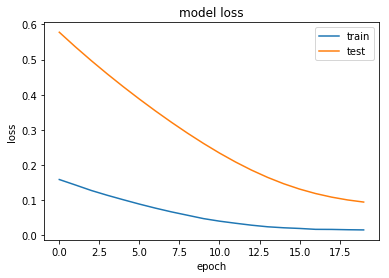

278
Train on 278 samples, validate on 120 samples
Epoch 1/20
 - 4s - loss: 0.1455 - val_loss: 0.5653
Epoch 2/20
 - 0s - loss: 0.1288 - val_loss: 0.5199
Epoch 3/20
 - 0s - loss: 0.1136 - val_loss: 0.4762
Epoch 4/20
 - 0s - loss: 0.0991 - val_loss: 0.4343
Epoch 5/20
 - 0s - loss: 0.0855 - val_loss: 0.3943
Epoch 6/20
 - 0s - loss: 0.0728 - val_loss: 0.3561
Epoch 7/20
 - 0s - loss: 0.0623 - val_loss: 0.3199
Epoch 8/20
 - 0s - loss: 0.0527 - val_loss: 0.2860
Epoch 9/20
 - 0s - loss: 0.0438 - val_loss: 0.2544
Epoch 10/20
 - 0s - loss: 0.0365 - val_loss: 0.2254
Epoch 11/20
 - 0s - loss: 0.0306 - val_loss: 0.1992
Epoch 12/20
 - 0s - loss: 0.0257 - val_loss: 0.1761
Epoch 13/20
 - 0s - loss: 0.0226 - val_loss: 0.1559
Epoch 14/20
 - 0s - loss: 0.0196 - val_loss: 0.1387
Epoch 15/20
 - 0s - loss: 0.0180 - val_loss: 0.1245
Epoch 16/20
 - 0s - loss: 0.0179 - val_loss: 0.1131
Epoch 17/20
 - 0s - loss: 0.0166 - val_loss: 0.1042
Epoch 18/20
 - 0s - loss: 0.0154 - val_loss: 0.0975
Epoch 19/20
 - 0s - los

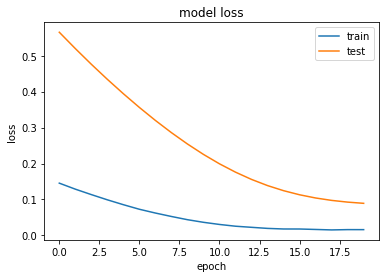

389
Train on 389 samples, validate on 168 samples
Epoch 1/20
 - 4s - loss: 0.3936 - val_loss: 0.2179
Epoch 2/20
 - 0s - loss: 0.3509 - val_loss: 0.1890
Epoch 3/20
 - 0s - loss: 0.3109 - val_loss: 0.1618
Epoch 4/20
 - 0s - loss: 0.2727 - val_loss: 0.1362
Epoch 5/20
 - 0s - loss: 0.2352 - val_loss: 0.1121
Epoch 6/20
 - 0s - loss: 0.2002 - val_loss: 0.0897
Epoch 7/20
 - 0s - loss: 0.1682 - val_loss: 0.0694
Epoch 8/20
 - 0s - loss: 0.1381 - val_loss: 0.0514
Epoch 9/20
 - 0s - loss: 0.1099 - val_loss: 0.0362
Epoch 10/20
 - 0s - loss: 0.0847 - val_loss: 0.0240
Epoch 11/20
 - 0s - loss: 0.0646 - val_loss: 0.0151
Epoch 12/20
 - 0s - loss: 0.0474 - val_loss: 0.0093
Epoch 13/20
 - 0s - loss: 0.0344 - val_loss: 0.0064
Epoch 14/20
 - 0s - loss: 0.0253 - val_loss: 0.0057
Epoch 15/20
 - 0s - loss: 0.0195 - val_loss: 0.0064
Epoch 16/20
 - 0s - loss: 0.0157 - val_loss: 0.0077
Epoch 17/20
 - 0s - loss: 0.0141 - val_loss: 0.0091
Epoch 18/20
 - 0s - loss: 0.0142 - val_loss: 0.0102
Epoch 19/20
 - 0s - los

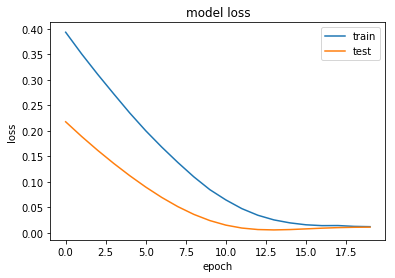

389
Train on 389 samples, validate on 168 samples
Epoch 1/20
 - 4s - loss: 0.4404 - val_loss: 0.2769
Epoch 2/20
 - 0s - loss: 0.3896 - val_loss: 0.2402
Epoch 3/20
 - 0s - loss: 0.3425 - val_loss: 0.2062
Epoch 4/20
 - 0s - loss: 0.2983 - val_loss: 0.1745
Epoch 5/20
 - 0s - loss: 0.2559 - val_loss: 0.1451
Epoch 6/20
 - 0s - loss: 0.2164 - val_loss: 0.1180
Epoch 7/20
 - 0s - loss: 0.1798 - val_loss: 0.0934
Epoch 8/20
 - 0s - loss: 0.1460 - val_loss: 0.0716
Epoch 9/20
 - 0s - loss: 0.1146 - val_loss: 0.0530
Epoch 10/20
 - 0s - loss: 0.0886 - val_loss: 0.0379
Epoch 11/20
 - 0s - loss: 0.0652 - val_loss: 0.0264
Epoch 12/20
 - 0s - loss: 0.0485 - val_loss: 0.0185
Epoch 13/20
 - 0s - loss: 0.0345 - val_loss: 0.0139
Epoch 14/20
 - 0s - loss: 0.0240 - val_loss: 0.0120
Epoch 15/20
 - 0s - loss: 0.0177 - val_loss: 0.0118
Epoch 16/20
 - 0s - loss: 0.0140 - val_loss: 0.0126
Epoch 17/20
 - 0s - loss: 0.0125 - val_loss: 0.0136
Epoch 18/20
 - 0s - loss: 0.0120 - val_loss: 0.0144
Epoch 19/20
 - 0s - los

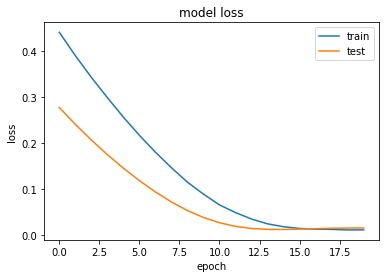

256
Train on 256 samples, validate on 111 samples
Epoch 1/20
 - 4s - loss: 0.3314 - val_loss: 0.4682
Epoch 2/20
 - 0s - loss: 0.3019 - val_loss: 0.4326
Epoch 3/20
 - 0s - loss: 0.2778 - val_loss: 0.3987
Epoch 4/20
 - 0s - loss: 0.2541 - val_loss: 0.3662
Epoch 5/20
 - 0s - loss: 0.2297 - val_loss: 0.3350
Epoch 6/20
 - 0s - loss: 0.2074 - val_loss: 0.3051
Epoch 7/20
 - 0s - loss: 0.1870 - val_loss: 0.2764
Epoch 8/20
 - 0s - loss: 0.1677 - val_loss: 0.2491
Epoch 9/20
 - 0s - loss: 0.1478 - val_loss: 0.2230
Epoch 10/20
 - 0s - loss: 0.1293 - val_loss: 0.1984
Epoch 11/20
 - 0s - loss: 0.1142 - val_loss: 0.1753
Epoch 12/20
 - 0s - loss: 0.1006 - val_loss: 0.1539
Epoch 13/20
 - 0s - loss: 0.0864 - val_loss: 0.1343
Epoch 14/20
 - 0s - loss: 0.0755 - val_loss: 0.1165
Epoch 15/20
 - 0s - loss: 0.0642 - val_loss: 0.1007
Epoch 16/20
 - 0s - loss: 0.0551 - val_loss: 0.0867
Epoch 17/20
 - 0s - loss: 0.0459 - val_loss: 0.0747
Epoch 18/20
 - 0s - loss: 0.0423 - val_loss: 0.0645
Epoch 19/20
 - 0s - los

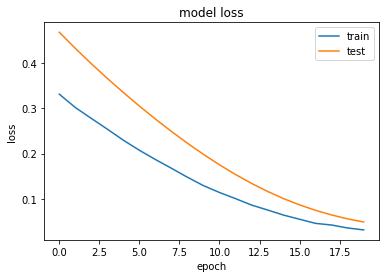

256
Train on 256 samples, validate on 111 samples
Epoch 1/20
 - 4s - loss: 0.3193 - val_loss: 0.5270
Epoch 2/20
 - 0s - loss: 0.2919 - val_loss: 0.4894
Epoch 3/20
 - 0s - loss: 0.2698 - val_loss: 0.4539
Epoch 4/20
 - 0s - loss: 0.2460 - val_loss: 0.4201
Epoch 5/20
 - 0s - loss: 0.2253 - val_loss: 0.3878
Epoch 6/20
 - 0s - loss: 0.2038 - val_loss: 0.3570
Epoch 7/20
 - 0s - loss: 0.1854 - val_loss: 0.3276
Epoch 8/20
 - 0s - loss: 0.1670 - val_loss: 0.2995
Epoch 9/20
 - 0s - loss: 0.1498 - val_loss: 0.2726
Epoch 10/20
 - 0s - loss: 0.1342 - val_loss: 0.2471
Epoch 11/20
 - 0s - loss: 0.1197 - val_loss: 0.2229
Epoch 12/20
 - 0s - loss: 0.1065 - val_loss: 0.2002
Epoch 13/20
 - 0s - loss: 0.0935 - val_loss: 0.1789
Epoch 14/20
 - 0s - loss: 0.0822 - val_loss: 0.1592
Epoch 15/20
 - 0s - loss: 0.0718 - val_loss: 0.1410
Epoch 16/20
 - 0s - loss: 0.0620 - val_loss: 0.1246
Epoch 17/20
 - 0s - loss: 0.0542 - val_loss: 0.1097
Epoch 18/20
 - 0s - loss: 0.0468 - val_loss: 0.0966
Epoch 19/20
 - 0s - los

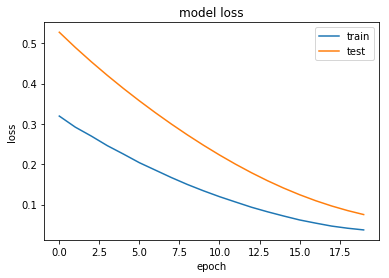

In [9]:
trajectory = predict_next_location_ext_user(36,"B1")

### The predicted trajectory(in terms of lat and long) for mac id 36 on level B1 is as follows:

In [8]:
trajectory

[(array([0.23356889], dtype=float32), array([0.2324574], dtype=float32)),
 (array([0.5209819], dtype=float32), array([0.40487352], dtype=float32)),
 (array([0.36866826], dtype=float32), array([0.45607218], dtype=float32)),
 (array([0.35708156], dtype=float32), array([0.32998845], dtype=float32)),
 (array([0.15145487], dtype=float32), array([0.15945959], dtype=float32)),
 (array([0.08149529], dtype=float32), array([0.07680465], dtype=float32)),
 (array([0.4991462], dtype=float32), array([0.36808005], dtype=float32)),
 (array([0.08339626], dtype=float32), array([0.08090115], dtype=float32)),
 (array([0.30959368], dtype=float32), array([0.24000353], dtype=float32)),
 (array([0.59006315], dtype=float32), array([0.6089355], dtype=float32)),
 (array([0.50361353], dtype=float32), array([0.4968422], dtype=float32)),
 (array([0.4531039], dtype=float32), array([0.50154155], dtype=float32))]